<p style="font-size:36px;text-align:center"> <b> Amazon Fine Food Reviews Analysis</b> </p>


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [32]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import re
import seaborn as sns
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from mlxtend.classifier import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from  sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#  Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [3]:
#checking for null values
final.isnull().sum()

Unnamed: 0                 0
Id                         0
ProductId                  0
UserId                     0
ProfileName               11
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                    1
Text                       0
CleanedText                3
dtype: int64

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

## [2.2]  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# find sentences containing HTML tags
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [17]:
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'now', 'because', 'our', 'y', 'any', 'shouldn', 'then', 'this', "doesn't", 'is', 'very', 'on', 'needn', 'to', 'not', 'themselves', 'did', 'and', 'ain', 'at', 'some', 'an', 'isn', 'own', "hadn't", 'such', 'about', "you're", 'has', 'so', 'me', 'haven', 'shan', "hasn't", 'where', "wouldn't", 'hadn', 'same', 'should', 'its', 'herself', 'while', "mustn't", 'he', 'into', 'which', 'by', 'ours', 'that', 'why', 'are', 'hers', "weren't", 'those', 'of', 're', 'wasn', 'few', 'if', 'further', 'o', "you'd", 't', "didn't", 'having', 'as', 'both', "she's", 'doing', 'than', 'or', "shan't", 'his', 'mightn', 'in', 'each', "don't", 'during', 'through', "aren't", "haven't", 'been', 'only', 'd', 'can', 'll', 'too', 'but', 'their', 'down', 'against', 'for', 'does', 'won', 'they', 'don', 'after', 'them', 'between', 'these', 'there', 'do', 'she', "it's", 'above', "won't", 've', "mightn't", 'mustn', 'hasn', 'off', 'be', 'no', 'just', "you've", "isn't", 'more', 'wouldn', 'how', 'myself', 'up', 'ourselves', 'bel

- Not is a stop words .'not' is imprtant word because it is used with positive word to make it negative

In [22]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(final['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                #if(cleaned_words.lower() not in stop):
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence.append(s)
                if (final['Score'].values)[i] == 'positive': 
                    all_positive_words.append(s) #list of all words used to describe positive reviews
                if(final['Score'].values)[i] == 'negative':
                    all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

100%|██████████| 364171/364171 [22:27<00:00, 270.18it/s]


In [25]:
str(final_string[0])

"b'this witti littl book make son laugh loud recit the car were drive along and alway can sing the refrain hes learn about whale india droop love all the new word this book introduc and the silli all this classic book will bet son will still abl recit from memori when colleg'"

In [26]:
#converting final_string into list of string
list_of_string=[str(str1)[2:-1] for str1 in tqdm(final_string)]
print(list_of_string[0])  
#adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=list_of_string 

100%|██████████| 364171/364171 [00:01<00:00, 205579.32it/s]

this witti littl book make son laugh loud recit the car were drive along and alway can sing the refrain hes learn about whale india droop love all the new word this book introduc and the silli all this classic book will bet son will still abl recit from memori when colleg


In [2]:
#loading pre-processed data (saved earlier) from csv file
final=pd.read_csv('Reviews.csv',usecols=['CleanedText',"Score"])
final.head(5)

,Score,CleanedText
0,positive,this witti littl book make son laugh loud reci...
1,positive,grew read these sendak book and watch the real...
2,positive,this fun way for children learn their month th...
3,positive,this great littl book read has nice rhythm wel...
4,positive,this book poetri about the month the year goe ...


In [5]:
#checking null value in preprocessed data
final.CleanedText.isnull().sum()

3

In [6]:
#filling null values with whitespace
final.CleanedText=final.CleanedText.fillna(' ')
final.CleanedText.isnull().sum()

0

#  Exploratory Data Analysis on Reviews

# [3.1] Basic stats about reviews

In [33]:
print("There are {} data points after text preprocessing".format(final.shape[0]))

There are 364171 data points after text preprocessing


In [34]:
final.CleanedText.head(3)

138706    this witti littl book make son laugh loud reci...
138688    grew read these sendak book and watch the real...
138689    this fun way for children learn their month th...
Name: CleanedText, dtype: object

# [3.1] Distribution of data among output class

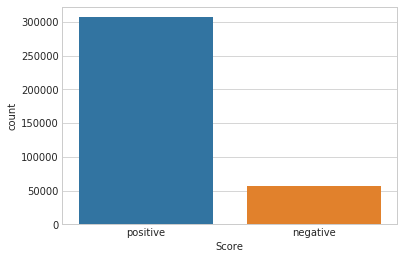

In [38]:
sns.set_style("whitegrid")
ax = sns.countplot(x="Score", data=final)

In [51]:
value_count=final['Score'].value_counts()
print("{}% data having positive reviews".format(round(value_count[0]/final.shape[0]*100,2)))
print("{}% data having negative reviews".format(round(value_count[1]/final.shape[0]*100,2)))

84.32% data having positive reviews
15.68% data having negative reviews


- Dataset is highly imbalanced.There is high chance our model may be biased(underfit) towards dominating class. So,we have to take care of this while applying ML model

<h3> Feature :HelpfulnessNumerator</h3>

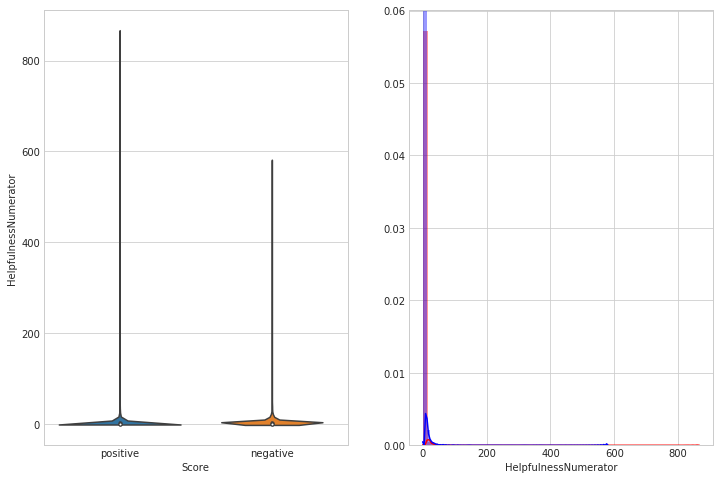

In [55]:

plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'Score', y = 'HelpfulnessNumerator', data = final)

plt.subplot(1,2,2)
sns.distplot(final[final['Score'] == 'positive']['HelpfulnessNumerator'] , label = "positive", color = 'red')
sns.distplot(final[final['Score'] =='negative']['HelpfulnessNumerator'] , label = "negative" , color = 'blue' )
plt.show()

- It seem's that HelpfulnessNumerator is not so useful for determing class label

<h3> Feature :HelpfulnessDenominator</h3>

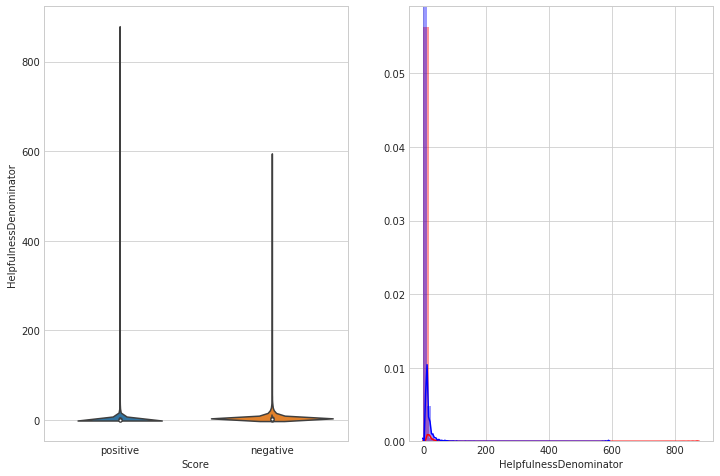

In [56]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'Score', y = 'HelpfulnessDenominator', data = final)

plt.subplot(1,2,2)
sns.distplot(final[final['Score'] == 'positive']['HelpfulnessDenominator'] , label = "positive", color = 'red')
sns.distplot(final[final['Score'] =='negative']['HelpfulnessDenominator'] , label = "negative" , color = 'blue' )
plt.show()

* Like HelpfulnessNumerator ,HelpfulnessDenominator is also not so useful for dteetmining the sentiments of reviews

<h3> Handcrafted Feature:Review length & TextSummary lengt</h3> 

In [60]:
#adding feature to the final dataframe
final['review_len']=final.CleanedText.apply(len)
final['summary_len']=final.Summary.apply(len)

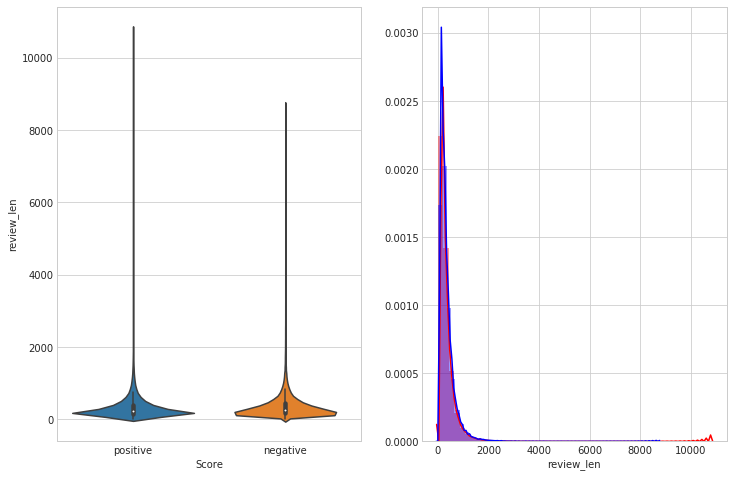

In [61]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'Score', y = 'review_len', data = final)

plt.subplot(1,2,2)
sns.distplot(final[final['Score'] == 'positive']['review_len'] , label = "positive", color = 'red')
sns.distplot(final[final['Score'] =='negative']['review_len'] , label = "negative" , color = 'blue' )
plt.show()

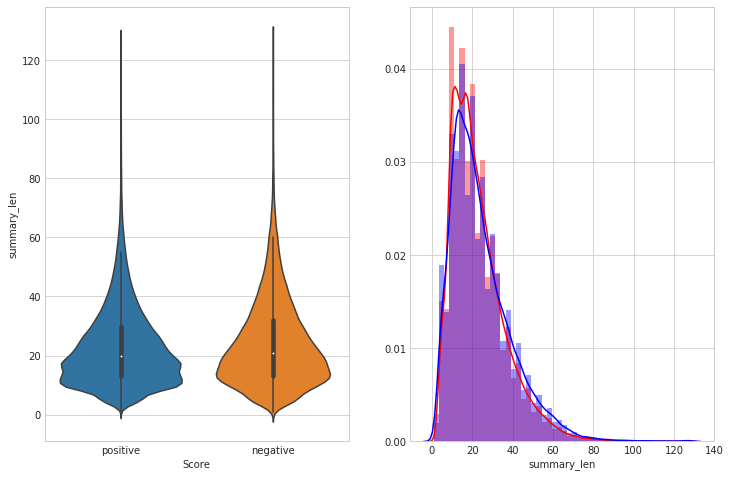

In [62]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'Score', y = 'summary_len', data = final)

plt.subplot(1,2,2)
sns.distplot(final[final['Score'] == 'positive']['summary_len'] , label = "positive", color = 'red')
sns.distplot(final[final['Score'] =='negative']['summary_len'] , label = "negative" , color = 'blue' )
plt.show()

- In above two plot histogram is almost overlapping and voilin plot is also simailar for both class label.Hence ,these two feature is also not so useful to determining class label.Therefore we have to rely on review text

<h1> 4.Machine Learning problem </h1>

<h3>  4.1.1.Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given reviews text we need to predict either it is semantically positive or negative. </p>

<h3> 4.1.2 Performance Metric </h3>

Metric(s): 
* Area under ROC
* Binary Confusion Matrix

<h2> 4.2.Train Test and CrossValiadation split</h2>

In [3]:
X=final.CleanedText
X=X.fillna(' ')
#converting positive class to 1 and negative class to 0
y_dict = {'positive':1, 'negative':0}
y_true=final.Score.map(y_dict)
# split the data into test and train 
X_train, test_text, y_train, y_test = train_test_split(X, y_true, test_size=0.2)
# split the train data into train and cross validation 
train_text, cv_text, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2)

<p> We split the data into train, test and cross validation data sets in ratio of 64:20:16 </p>

In [4]:
print('Number of data points in train data:', train_text.shape[0])
print('Number of data points in test data:', test_text.shape[0])
print('Number of data points in cross validation data:', cv_text.shape[0])

Number of data points in train data: 233068
Number of data points in test data: 72835
Number of data points in cross validation data: 58268


<h2> How to convert Text into Vector </h2>

We will do this in two ways:
* Tf-idf Representation
* Glove representation

In [5]:
text_vectorizer=TfidfVectorizer(min_df=3)
train_text_tfidfvector=text_vectorizer.fit_transform(train_text)
test_text_tfidfvector=text_vectorizer.transform(test_text)
cv_text_tfidfvector=text_vectorizer.transform(cv_text)

In [6]:
print('Number of  features in train data:', train_text_tfidfvector.shape[1])
print('Number of  features in test data::', test_text_tfidfvector.shape[1])
print('Number of  features in cross validation data:', cv_text_tfidfvector.shape[1])

Number of  features in train data: 22497
Number of  features in test data:: 22497
Number of  features in cross validation data: 22497


In [2]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divide each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    #cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.3.ML Model with Tf-idf respresentation</h2> 

<h3>4.3.1.Naive Bayes with hyperparameter tuning</h3>

for alpha = 1e-15
ROC_AUC_Score : 0.837145185942112
for alpha = 1e-12
ROC_AUC_Score : 0.837145185942112
for alpha = 1e-10
ROC_AUC_Score : 0.837145185942112
for alpha = 0.9999997697415172
ROC_AUC_Score : 0.838389576352321
for alpha = 1e-06
ROC_AUC_Score : 0.8400363033793925
for alpha = 1e-05
ROC_AUC_Score : 0.8416103920183172
for alpha = 0.0001
ROC_AUC_Score : 0.8431679576569273
for alpha = 0.001
ROC_AUC_Score : 0.8463619908268615
for alpha = 0.1
ROC_AUC_Score : 0.8555548464935756
for alpha = 1
ROC_AUC_Score : 0.838389576352321
for alpha = 10
ROC_AUC_Score : 0.5637900497324936


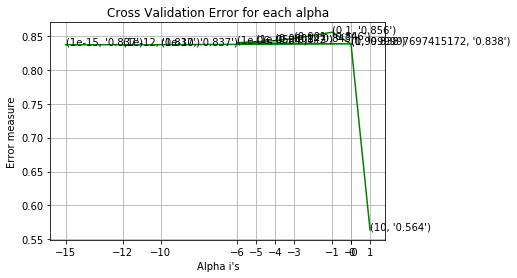

For values of best alpha =  0.1 The train roc_auc_score is: 0.8787372241003143
For values of best alpha =  0.1 The cross validation roc_auc_score is: 0.8555548464935756
For values of best alpha =  0.1 The test roc_auc_score is: 0.8541259948478321


In [30]:
alpha = [10**-15,10**-12,10**-10,10**-10**-7,10**-6,0.00001, 0.0001, 0.001, 0.1, 1, 10]
cv_auc_score = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i,fit_prior=False)
    clf.fit(train_text_tfidfvector,y_train)
    y_pred= clf.predict(cv_text_tfidfvector)
    cv_auc_score.append(roc_auc_score(y_cv,y_pred))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("ROC_AUC_Score :",roc_auc_score(y_cv,y_pred)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_auc_score,c='g')
for i, txt in enumerate(np.round(cv_auc_score,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_auc_score[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmax(cv_auc_score)
clf = MultinomialNB(alpha=alpha[best_alpha],fit_prior=False)
clf.fit(train_text_tfidfvector,y_train)


y_pred = clf.predict(train_text_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The train roc_auc_score is:",roc_auc_score(y_train,y_pred))
y_pred = clf.predict(cv_text_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation roc_auc_score is:",roc_auc_score(y_cv,y_pred))
y_pred = clf.predict(test_text_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The test roc_auc_score is:",roc_auc_score(y_test,y_pred))

Number of missclassified point : 0.1332051898125901


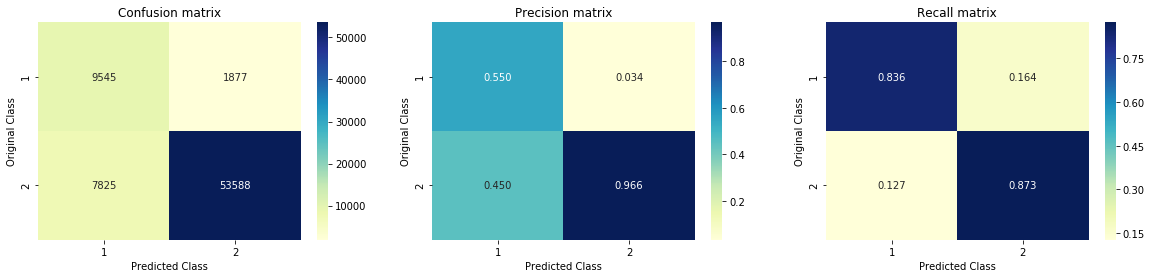

In [36]:
#confusion matrix and % of misclassified point
print("Number of missclassified point :", np.count_nonzero((clf.predict(test_text_tfidfvector)- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,clf.predict(test_text_tfidfvector))

<h3>4.3.2.1.Logistic Regression with hyperparameter tuning with balanced class</h3>

for alpha = 1e-08
ROC_AUC_Score : 0.848233411056921
for alpha = 1e-07
ROC_AUC_Score : 0.8486340303330923
for alpha = 1e-06
ROC_AUC_Score : 0.8828185677004433
for alpha = 1e-05
ROC_AUC_Score : 0.8894748332074618
for alpha = 0.0001
ROC_AUC_Score : 0.8759866233638431
for alpha = 0.001
ROC_AUC_Score : 0.8437988654147053
for alpha = 0.01
ROC_AUC_Score : 0.8118369455623493
for alpha = 0.1
ROC_AUC_Score : 0.7623091607941856
for alpha = 1
ROC_AUC_Score : 0.7467244254448503
for alpha = 10
ROC_AUC_Score : 0.5


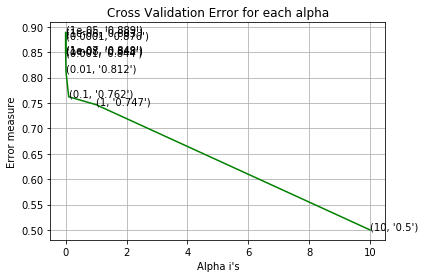

For values of best alpha =  1e-05 The train roc_auc_score is: 0.9033467237797468
For values of best alpha =  1e-05 The cross validation roc_auc_score is: 0.8894748332074618
For values of best alpha =  1e-05 The test roc_auc_score is: 0.8931476045781509


In [39]:
alpha = [10 ** x for x in range(-8, 2)]
cv_auc_score= []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_tfidfvector, y_train)
    y_pred= clf.predict(cv_text_tfidfvector)
    cv_auc_score.append(roc_auc_score(y_cv,y_pred))
    print("ROC_AUC_Score :",roc_auc_score(y_cv,y_pred)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_score,c='g')
for i, txt in enumerate(np.round(cv_auc_score,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_auc_score[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmax(cv_auc_score)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_tfidfvector,y_train)


y_pred = clf.predict(train_text_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The train roc_auc_score is:",roc_auc_score(y_train,y_pred))
y_pred = clf.predict(cv_text_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation roc_auc_score is:",roc_auc_score(y_cv,y_pred))
y_pred = clf.predict(test_text_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The test roc_auc_score is:",roc_auc_score(y_test,y_pred))

Number of missclassified point : 0.11060616461865862


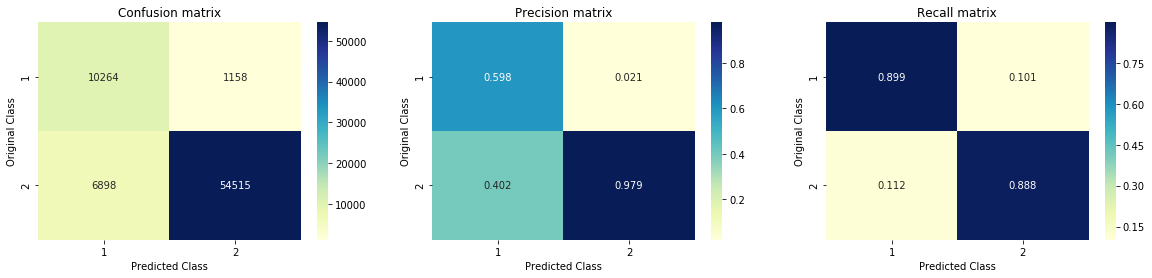

In [40]:
#confusion matrix and % of misclassified point
print("Number of missclassified point :", np.count_nonzero((clf.predict(test_text_tfidfvector)- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,clf.predict(test_text_tfidfvector))

<h3>4.3.2.2.Logistic Regression with hyperparameter tuning without balanced class</h3>

for alpha = 1e-08
ROC_AUC_Score : 0.8117830509120905
for alpha = 1e-07
ROC_AUC_Score : 0.815742289663743
for alpha = 1e-06
ROC_AUC_Score : 0.8375775771347692
for alpha = 1e-05
ROC_AUC_Score : 0.8081489419510781
for alpha = 0.0001
ROC_AUC_Score : 0.6917815536404794
for alpha = 0.001
ROC_AUC_Score : 0.502133946158897
for alpha = 0.01
ROC_AUC_Score : 0.5
for alpha = 0.1
ROC_AUC_Score : 0.5
for alpha = 1
ROC_AUC_Score : 0.5
for alpha = 10
ROC_AUC_Score : 0.5


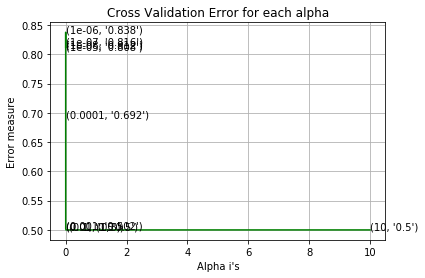

For values of best alpha =  1e-06 The train roc_auc_score is: 0.8649247913701482
For values of best alpha =  1e-06 The cross validation roc_auc_score is: 0.8375775771347692
For values of best alpha =  1e-06 The test roc_auc_score is: 0.8381257718498576


In [41]:
alpha = [10 ** x for x in range(-8, 2)]
cv_auc_score= []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_tfidfvector, y_train)
    y_pred= clf.predict(cv_text_tfidfvector)
    cv_auc_score.append(roc_auc_score(y_cv,y_pred))
    print("ROC_AUC_Score :",roc_auc_score(y_cv,y_pred)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_score,c='g')
for i, txt in enumerate(np.round(cv_auc_score,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_auc_score[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmax(cv_auc_score)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_tfidfvector,y_train)


y_pred = clf.predict(train_text_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The train roc_auc_score is:",roc_auc_score(y_train,y_pred))
y_pred = clf.predict(cv_text_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation roc_auc_score is:",roc_auc_score(y_cv,y_pred))
y_pred = clf.predict(test_text_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The test roc_auc_score is:",roc_auc_score(y_test,y_pred))

Number of missclassified point : 0.07353607468936638


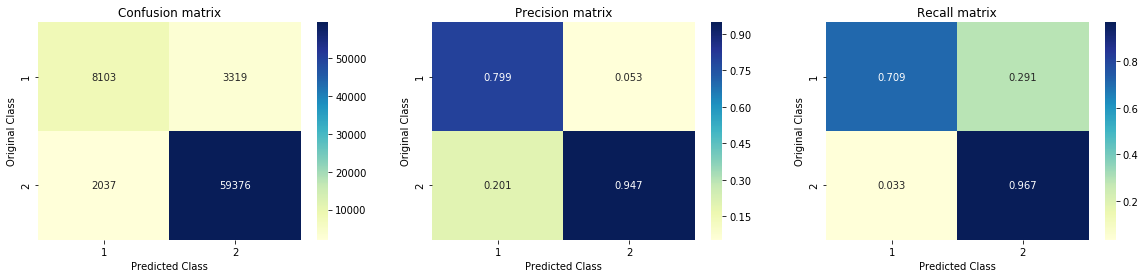

In [42]:
#confusion matrix and % of misclassified point
print("Number of missclassified point :", np.count_nonzero((clf.predict(test_text_tfidfvector)- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,clf.predict(test_text_tfidfvector))

<h3>4.3.3.Linear SVM with hyperparameter tuning </h3>

for alpha = 1e-08
ROC_AUC_Score : 0.8511259451332147
for alpha = 1e-07
ROC_AUC_Score : 0.8584762412486344
for alpha = 1e-06
ROC_AUC_Score : 0.872039167663103
for alpha = 1e-05
ROC_AUC_Score : 0.8885672487226527
for alpha = 0.0001
ROC_AUC_Score : 0.8852241543901309
for alpha = 0.001
ROC_AUC_Score : 0.8605159252276545
for alpha = 0.01
ROC_AUC_Score : 0.7792449153685153
for alpha = 0.1
ROC_AUC_Score : 0.700087161165452
for alpha = 1
ROC_AUC_Score : 0.7362535787397588
for alpha = 10
ROC_AUC_Score : 0.5


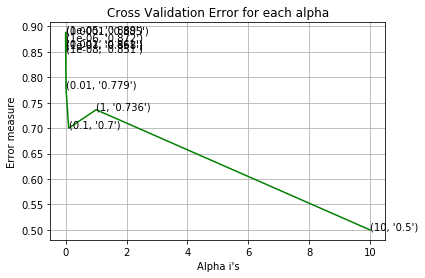

For values of best alpha =  1e-05 The train roc_auc_score is: 0.9073531613572879
For values of best alpha =  1e-05 The cross validation roc_auc_score is: 0.8885672487226527
For values of best alpha =  1e-05 The test roc_auc_score is: 0.8899416166542844


In [44]:
cv_auc_score= []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced',alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_text_tfidfvector, y_train)
    y_pred= clf.predict(cv_text_tfidfvector)
    cv_auc_score.append(roc_auc_score(y_cv,y_pred))
    print("ROC_AUC_Score :",roc_auc_score(y_cv,y_pred)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_score,c='g')
for i, txt in enumerate(np.round(cv_auc_score,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_auc_score[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmax(cv_auc_score)
clf = SGDClassifier(class_weight='balanced',alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_text_tfidfvector,y_train)


y_pred = clf.predict(train_text_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The train roc_auc_score is:",roc_auc_score(y_train,y_pred))
y_pred = clf.predict(cv_text_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation roc_auc_score is:",roc_auc_score(y_cv,y_pred))
y_pred = clf.predict(test_text_tfidfvector)
print('For values of best alpha = ', alpha[best_alpha], "The test roc_auc_score is:",roc_auc_score(y_test,y_pred))

Number of missclassified point : 0.12370426306034187


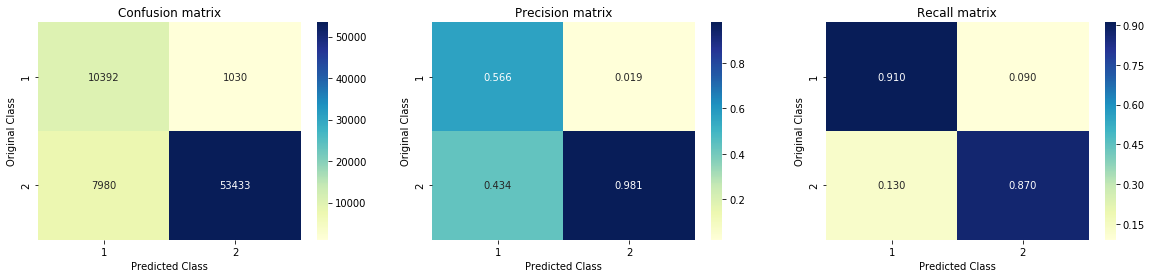

In [45]:
#confusion matrix and % of misclassified point
print("Number of missclassified point :", np.count_nonzero((clf.predict(test_text_tfidfvector)- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,clf.predict(test_text_tfidfvector))

<h3>4.3.4.stacking classifer with hyperparameter tuning </h3>

In [50]:
clf1 = SGDClassifier(alpha=10**-5, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_text_tfidfvector, y_train)

clf2 = SGDClassifier(alpha=10**-5, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_text_tfidfvector,y_train)

clf3 = MultinomialNB(alpha=0.1,fit_prior=False)
clf3.fit(train_text_tfidfvector,y_train)


print("Logistic Regression :  roc_auc_score: %0.2f" % (roc_auc_score(y_cv, clf1.predict(cv_text_tfidfvector))))
print("Support vector machines : roc_auc_score: %0.2f" % (roc_auc_score(y_cv, clf2.predict(cv_text_tfidfvector))))
print("Naive Bayes : roc_auc_score: %0.2f" % (roc_auc_score(y_cv, clf3.predict(cv_text_tfidfvector))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[clf1,clf2,clf3], meta_classifier=lr)
    sclf.fit(train_text_tfidfvector, y_train)
    print("Stacking Classifer : for the value of alpha: %f roc_auc_score: %f" % (i, roc_auc_score(y_cv, sclf.predict(cv_text_tfidfvector))))
    roc_auc_score_value =roc_auc_score(y_cv,sclf.predict(cv_text_tfidfvector))
    if best_alpha > roc_auc_score_value:
        best_alpha = roc_auc_score_value

Logistic Regression :  roc_auc_score: 0.89
Support vector machines : roc_auc_score: 0.89
Naive Bayes : roc_auc_score: 0.86
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 roc_auc_score: 0.500000
Stacking Classifer : for the value of alpha: 0.001000 roc_auc_score: 0.865250
Stacking Classifer : for the value of alpha: 0.010000 roc_auc_score: 0.865250
Stacking Classifer : for the value of alpha: 0.100000 roc_auc_score: 0.865250
Stacking Classifer : for the value of alpha: 1.000000 roc_auc_score: 0.865250
Stacking Classifer : for the value of alpha: 10.000000 roc_auc_score: 0.865250


Number of missclassified point : 0.08935264639253106


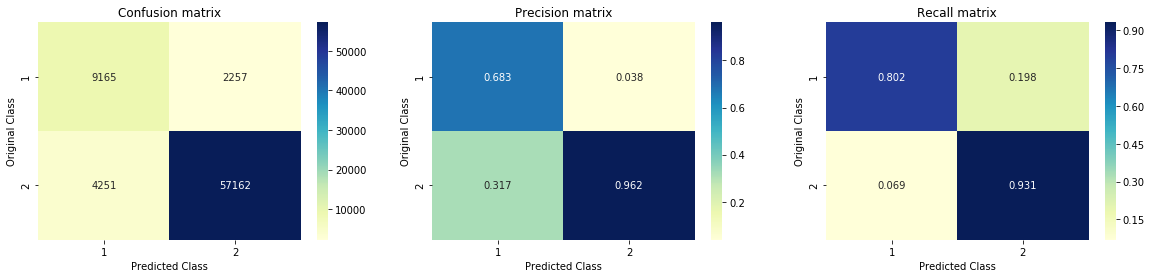

In [51]:
#confusion matrix and % of misclassified point
print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_text_tfidfvector)- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,sclf.predict(test_text_tfidfvector))

<h2>4.4.ML Model with GloVe Representation</h2>

- we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [9]:
#converting text into 384 dimension of glove representation
# dict key:word and value:tf-idf score
word2tfidf = dict(zip(text_vectorizer.get_feature_names(), text_vectorizer.idf_))
import spacy
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en')
def glove_representation(data):
    vecs1 = []
    for txt1 in tqdm(list(data)):
        doc1 = nlp(txt1) 
        # 384 is the number of dimensions of vectors 
        mean_vec1 = np.zeros([len(doc1), 384])
        for word1 in doc1:
            # word2vec
            vec1 = word1.vector
            # fetch idf score
            try:
                idf = word2tfidf[str(word1)]
            except:
                idf = 0
            # compute final vec
            mean_vec1 += vec1 * idf
        mean_vec1 = mean_vec1.mean(axis=0)
        vecs1.append(mean_vec1)
    return pd.DataFrame(vecs1)

In [33]:
train_text=train_text[0:100000:]
y_train=y_train[0:100000:]
train_glove_vectordf=glove_representation(train_text)
train_glove_vectordf['Score']=list(y_train)
train_glove_vectordf.to_csv("train_golVe_representation.csv")

100%|██████████| 100000/100000 [2:00:07<00:00, 13.88it/s] 


In [34]:
train_glove_vectordf.head(3)

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,Score
0,78.472923,47.079843,13.575228,83.422813,34.580648,6.504574,-213.729293,-8.253369,58.033381,91.262906,...,39.093878,9.920168,-3.974682,18.734067,4.626833,-27.420101,-2.511963,-2.920110,1.121422,1
1,137.932337,110.931221,52.011327,48.060625,-4.559042,168.812472,-275.491204,-58.987431,126.740845,68.545134,...,29.380022,11.535613,-7.797929,13.234541,4.261814,-19.512211,19.486973,21.936246,9.510271,1
2,88.086722,104.423978,65.575189,135.675200,56.146511,92.516194,-324.746625,4.423292,95.168191,167.013489,...,56.444012,3.608051,-26.696657,40.676315,1.628654,-37.020352,-4.292193,4.031313,16.278295,1


In [10]:
cv_glove_vectordf=glove_representation(cv_text)

100%|██████████| 58268/58268 [1:08:51<00:00, 14.10it/s]


In [32]:
cv_glove_vectordf['Score']=list(y_cv)
cv_glove_vectordf.to_csv("cv_gloVe_representation.csv")
cv_glove_vectordf.head(3)

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,Score
0,32.167268,52.888463,38.417471,35.256808,10.768668,-7.023374,-119.350561,38.068577,24.669803,34.876232,...,21.861285,10.475271,-7.440868,12.348402,8.240131,-7.714332,5.279401,0.097818,3.541099,1
1,69.827286,207.091783,91.782151,209.616692,95.387094,62.986724,-725.783677,-3.738785,43.948253,251.340287,...,112.206454,33.383089,-40.132734,46.167418,14.478350,-55.663530,35.221098,20.649156,30.268599,1
2,52.257255,130.813428,24.503710,74.213488,-44.090023,5.955097,-159.870115,-82.305627,81.046260,123.145008,...,61.525891,-2.953137,-15.140593,26.407567,-2.333076,-26.138178,2.451993,-4.686232,17.069052,1


In [20]:
test_glove_vectordf=glove_representation(test_text)
test_glove_vectordf['Score']=list(y_test)
test_glove_vectordf.to_csv("test_gloVe_representation.csv")

100%|██████████| 72835/72835 [1:29:08<00:00, 13.62it/s]


In [21]:
test_glove_vectordf.head(3)

,0,1,2,3,4,5,6,7,8,9,...,375,376,377,378,379,380,381,382,383,Score
0,50.523988,99.243943,69.887608,42.314336,28.713650,88.030158,-287.568771,-67.105219,89.281776,174.642181,...,30.637774,5.800466,-9.571149,18.985461,11.790036,-24.905312,12.671470,5.320684,20.459132,1
1,25.562289,238.748478,200.402938,337.386855,43.037753,127.414084,-519.050942,-138.878461,102.944297,269.168427,...,97.044981,31.859991,-45.989824,54.966314,7.711640,-48.368189,-15.031954,16.786690,43.964812,0
2,213.996751,799.129486,222.844809,1041.178484,-243.379876,195.374588,-2209.376898,-240.104210,635.859519,814.338866,...,380.895822,76.461139,-130.679850,279.098208,31.128506,-278.503028,54.427883,3.890343,62.932172,1


In [17]:
#loading GloVe representation data
train_glove_df=pd.read_csv("train_golVe_representation.csv")
y_train=train_glove_df['Score']
train_glove_df=train_glove_df.drop('Score',axis=1)
cv_glove_df=pd.read_csv("cv_gloVe_representation.csv",nrows=25000)
y_cv=cv_glove_df['Score']
cv_glove_df=cv_glove_df.drop('Score',axis=1)
test_glove_df=pd.read_csv("test_gloVe_representation.csv",nrows=30000)
y_test=test_glove_df['Score']
test_glove_df=test_glove_df.drop('Score',axis=1)

In [18]:
print('Number of data points in train data:', train_glove_df.shape[0])
print('Number of data points in test data:', test_glove_df.shape[0])
print('Number of data points in cross validation data:', cv_glove_df.shape[0])

Number of data points in train data: 100000
Number of data points in test data: 30000
Number of data points in cross validation data: 25000


In [19]:
print('Number of features in train data:', train_glove_df.shape[1])
print('Number of features in test data:', test_glove_df.shape[1])
print('Number of features in cross validation data:', cv_glove_df.shape[1])

Number of features in train data: 384
Number of features in test data: 384
Number of features in cross validation data: 384


<h2> 4.4.1 K-NN with hyperparameter tuning</h2>

In [ ]:
#not implemented because it is highly time taking
k_neighbor = [5,10,20,35,45,50]
cv_auc_score = []
for i in k_neighbor:
    print("for k_neighbor =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_glove_df,y_train)
    y_pred= clf.predict(cv_glove_df)
    cv_auc_score.append(roc_auc_score(y_cv,y_pred))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("ROC_AUC_Score :",roc_auc_score(y_cv,y_pred)) 

fig, ax = plt.subplots()
ax.plot(k_neighbor, cv_auc_score,c='g')
for i, txt in enumerate(np.round(cv_auc_score,3)):
    ax.annotate((k_neighbor[i],str(txt)), (k_neighbor[i],cv_auc_score[i]))
plt.grid()
plt.xticks(k_neighbor)
plt.title("Cross Validation Error for each k_neighbor")
plt.xlabel("k_neighbor i's")
plt.ylabel("Error measure")
plt.show()


best_k_neighbor = np.argmax(cv_auc_score)
clf = KNeighborsClassifier(n_neighbors=k_neighbor[best_k_neighbor])
clf.fit(train_glove_df,y_train)


y_pred = clf.predict(train_glove_df)
print('For values of best k_neighbor = ', k_neighbor[best_k_neighbor], "The train roc_auc_score is:",roc_auc_score(y_train,y_pred))
y_pred = clf.predict(cv_glove_df)
print('For values of best k_neighbor = ', k_neighbor[best_k_neighbor], "The cross validation roc_auc_score is:",roc_auc_score(y_cv,y_pred))
y_pred = clf.predict(test_glove_df)
print('For values of best k_neighbor = ', k_neighbor[best_k_neighbor], "The test roc_auc_score is:",roc_auc_score(y_test,y_pred))

<h2> 4.4.2 Logistic Regression with hyperparameter tuning and balanced class</h2>

for alpha = 1e-08
ROC_AUC_Score : 0.654397901904258
for alpha = 1e-07
ROC_AUC_Score : 0.6631105606428576
for alpha = 1e-06
ROC_AUC_Score : 0.6743902620180526
for alpha = 1e-05
ROC_AUC_Score : 0.655553917503785
for alpha = 0.0001
ROC_AUC_Score : 0.666564415905854
for alpha = 0.001
ROC_AUC_Score : 0.6625796896550781
for alpha = 0.01
ROC_AUC_Score : 0.5243732722104194
for alpha = 0.1
ROC_AUC_Score : 0.6667508000649978
for alpha = 1
ROC_AUC_Score : 0.6279601765553705
for alpha = 10
ROC_AUC_Score : 0.6092484486619975


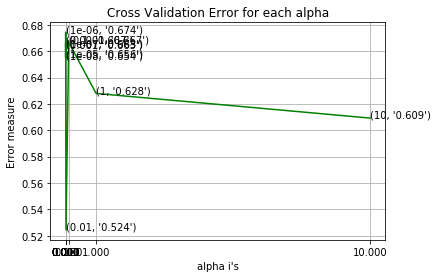

For values of best alpha =  1e-06 The train roc_auc_score is: 0.6758669199449571
For values of best alpha =  1e-06 The cross validation roc_auc_score is: 0.6743902620180526
For values of best alpha =  1e-06 The test roc_auc_score is: 0.666814570269243


In [22]:
alpha = [10 ** x for x in range(-8, 2)]
cv_auc_score = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_glove_df,y_train)
    y_pred= clf.predict(cv_glove_df)
    cv_auc_score.append(roc_auc_score(y_cv,y_pred))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("ROC_AUC_Score :",roc_auc_score(y_cv,y_pred)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_score,c='g')
for i, txt in enumerate(np.round(cv_auc_score,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_auc_score[i]))
plt.grid()
plt.xticks(alpha)
plt.title("Cross Validation Error for each alpha")
plt.xlabel("alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmax(cv_auc_score)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha],penalty='l2', loss='log', random_state=42)
clf.fit(train_glove_df,y_train)


y_pred = clf.predict(train_glove_df)
print('For values of best alpha = ', alpha[best_alpha], "The train roc_auc_score is:",roc_auc_score(y_train,y_pred))
y_pred = clf.predict(cv_glove_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation roc_auc_score is:",roc_auc_score(y_cv,y_pred))
y_pred = clf.predict(test_glove_df)
print('For values of best alpha = ', alpha[best_alpha], "The test roc_auc_score is:",roc_auc_score(y_test,y_pred))

Number of missclassified point : 0.17036666666666667


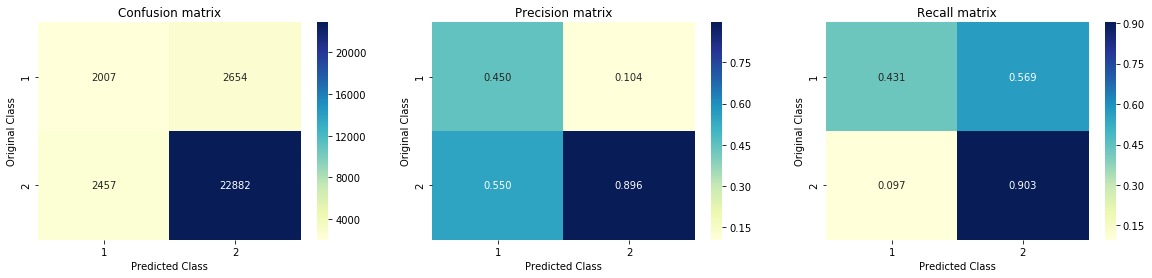

In [24]:
#confusion matrix and % of misclassified point
print("Number of missclassified point :", np.count_nonzero((clf.predict(test_glove_df)- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,clf.predict(test_glove_df))

<h2> 4.4.4 Logistic Regression with hyperparameter tuning and unbalanced class weight </h2>

for alpha = 1e-08
ROC_AUC_Score : 0.500125596583773
for alpha = 1e-07
ROC_AUC_Score : 0.500125596583773
for alpha = 1e-06
ROC_AUC_Score : 0.6231267187966286
for alpha = 1e-05
ROC_AUC_Score : 0.500125596583773
for alpha = 0.0001
ROC_AUC_Score : 0.6516482933785139
for alpha = 0.001
ROC_AUC_Score : 0.500125596583773
for alpha = 0.01
ROC_AUC_Score : 0.500125596583773
for alpha = 0.1
ROC_AUC_Score : 0.6454913240480418
for alpha = 1
ROC_AUC_Score : 0.500125596583773
for alpha = 10
ROC_AUC_Score : 0.5006279829188647


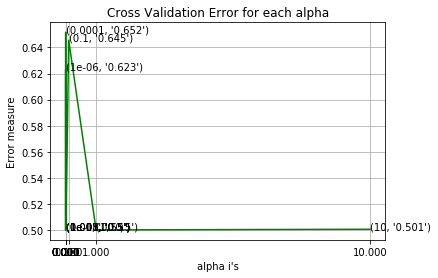

For values of best alpha =  0.0001 The train roc_auc_score is: 0.6530806598397343
For values of best alpha =  0.0001 The cross validation roc_auc_score is: 0.6516482933785139
For values of best alpha =  0.0001 The test roc_auc_score is: 0.6446161388199063


In [25]:
alpha = [10 ** x for x in range(-8, 2)]
cv_auc_score = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_glove_df,y_train)
    y_pred= clf.predict(cv_glove_df)
    cv_auc_score.append(roc_auc_score(y_cv,y_pred))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("ROC_AUC_Score :",roc_auc_score(y_cv,y_pred)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_auc_score,c='g')
for i, txt in enumerate(np.round(cv_auc_score,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_auc_score[i]))
plt.grid()
plt.xticks(alpha)
plt.title("Cross Validation Error for each alpha")
plt.xlabel("alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmax(cv_auc_score)
clf = SGDClassifier(alpha=alpha[best_alpha],penalty='l2', loss='log', random_state=42)
clf.fit(train_glove_df,y_train)


y_pred = clf.predict(train_glove_df)
print('For values of best alpha = ', alpha[best_alpha], "The train roc_auc_score is:",roc_auc_score(y_train,y_pred))
y_pred = clf.predict(cv_glove_df)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation roc_auc_score is:",roc_auc_score(y_cv,y_pred))
y_pred = clf.predict(test_glove_df)
print('For values of best alpha = ', alpha[best_alpha], "The test roc_auc_score is:",roc_auc_score(y_test,y_pred))

Number of missclassified point : 0.15433333333333332


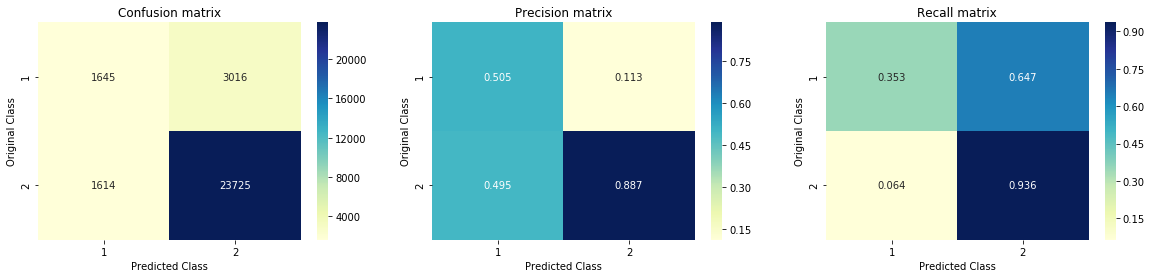

In [26]:
#confusion matrix and % of misclassified point
print("Number of missclassified point :", np.count_nonzero((clf.predict(test_glove_df)- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,clf.predict(test_glove_df))

<h2> 4.4.4 Random Forest with hyperparameter tuning </h2>

In [30]:
alpha = [100,200,500]
max_depth = [5, 10]
cv_auc_score = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = DecisionTreeClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_glove_df, y_train)
        y_pred=clf.predict(cv_glove_df)
        cv_auc_score.append(roc_auc_score(y_cv, y_pred))
        print("roc_auc_score :",roc_auc_score(y_cv, y_pred)) 


best_alpha = np.argmax(cv_auc_score)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_glove_df, y_train)

y_pred= clf.predict(train_glove_df)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train roc_auc_score is:",roc_auc_score(y_train,y_pred))
y_pred= clf.predict(cv_glove_df)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation roc_auc_score is:",roc_auc_score(y_cv,y_pred))
y_pred= clf.predict(test_glove_df)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test roc_auc_score is:",roc_auc_score(y_test,y_pred,))

for n_estimators = 100 and max depth =  5
roc_auc_score : 0.5
for n_estimators = 100 and max depth =  10
roc_auc_score : 0.5005804069162004
for n_estimators = 200 and max depth =  5
roc_auc_score : 0.5
for n_estimators = 200 and max depth =  10
roc_auc_score : 0.5003292137486545
for n_estimators = 500 and max depth =  5
roc_auc_score : 0.5
for n_estimators = 500 and max depth =  10
roc_auc_score : 0.5003292137486545
For values of best estimator =  100 The train roc_auc_score is: 0.5073538815705333
For values of best estimator =  100 The cross validation roc_auc_score is: 0.5005804069162004
For values of best estimator =  100 The test roc_auc_score is: 0.5003698951846094


Number of missclassified point : 0.15533333333333332


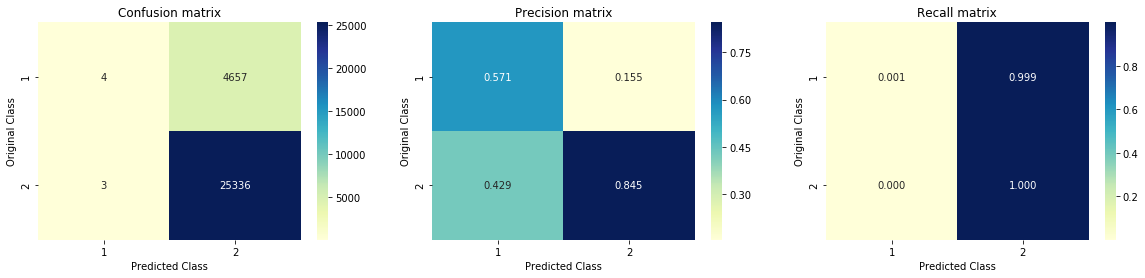

In [31]:
#confusion matrix and % of misclassified point
print("Number of missclassified point :", np.count_nonzero((clf.predict(test_glove_df)- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,clf.predict(test_glove_df))

- It seems Random Forest underfit 

<h2> 4.4.4 Decision Tree with hyperparameter tuning </h2> 

In [35]:
max_depth = [20,25,35,50,60,75]
cv_auc_score = []
for j in max_depth:
    print("max depth = ", j)
    clf = DecisionTreeClassifier(criterion='gini', max_depth=j, random_state=42)
    clf.fit(train_glove_df, y_train)
    y_pred=clf.predict(cv_glove_df)
    cv_auc_score.append(roc_auc_score(y_cv, y_pred))
    print("roc_auc_score :",roc_auc_score(y_cv, y_pred)) 


best_depth = np.argmax(cv_auc_score)
clf = DecisionTreeClassifier(criterion='gini', max_depth=j, random_state=42)
clf.fit(train_glove_df, y_train)

y_pred= clf.predict(train_glove_df)
print('For values of best depth = ', max_depth[best_depth], "The train roc_auc_score is:",roc_auc_score(y_train,y_pred))
y_pred= clf.predict(cv_glove_df)
print('For values of best depth = ', max_depth[best_depth], "The cross validation roc_auc_score is:",roc_auc_score(y_cv,y_pred))
y_pred= clf.predict(test_glove_df)
print('For values of best depth = ', max_depth[best_depth], "The test roc_auc_score is:",roc_auc_score(y_test,y_pred,))

max depth =  20
roc_auc_score : 0.544956173490668
max depth =  25
roc_auc_score : 0.5455924681678479
max depth =  35
roc_auc_score : 0.5507777445506625
max depth =  50
roc_auc_score : 0.5474321512841834
max depth =  60
roc_auc_score : 0.5455605357189358
max depth =  75
roc_auc_score : 0.546011527781368
For values of best depth =  35 The train roc_auc_score is: 0.9998661795683709
For values of best depth =  35 The cross validation roc_auc_score is: 0.546011527781368
For values of best depth =  35 The test roc_auc_score is: 0.5449513564103369


Number of missclassified point : 0.24786666666666668


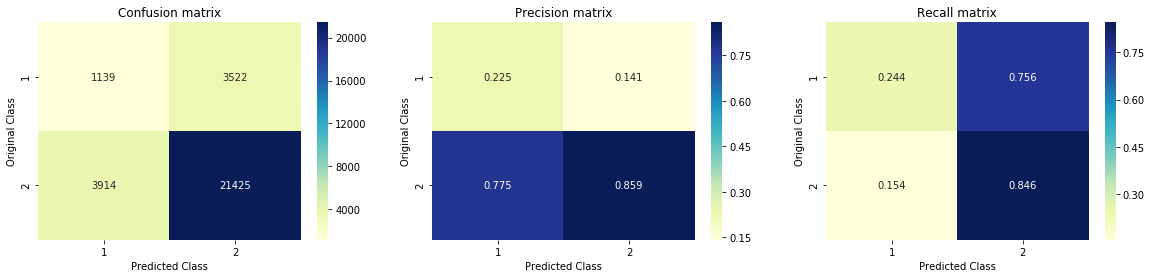

In [36]:
#confusion matrix and % of misclassified point
print("Number of missclassified point :", np.count_nonzero((clf.predict(test_glove_df)- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,clf.predict(test_glove_df))